# 📈 Storytelling: E-Commerce Data Insights

In this notebook, we will use the queries and functions from our EDA to uncover key business insights from the e-commerce database. We'll visualize trends and highlight actionable findings using Python and popular data visualization libraries.

---

## 1. Imports & Setup

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from database.database_connection import get_session
from database.models import (
    Usuario, Orden, DetalleOrden,
    MetodoPago, OrdenMetodoPago
)
from sqlalchemy import select, func, extract

session = get_session()

## 2. What day of the week has the most sales?


C:\Users\Pedro\AppData\Local\Temp\ipykernel_12384\2690089161.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_name', y='sales_count', data=df_days, palette='viridis')


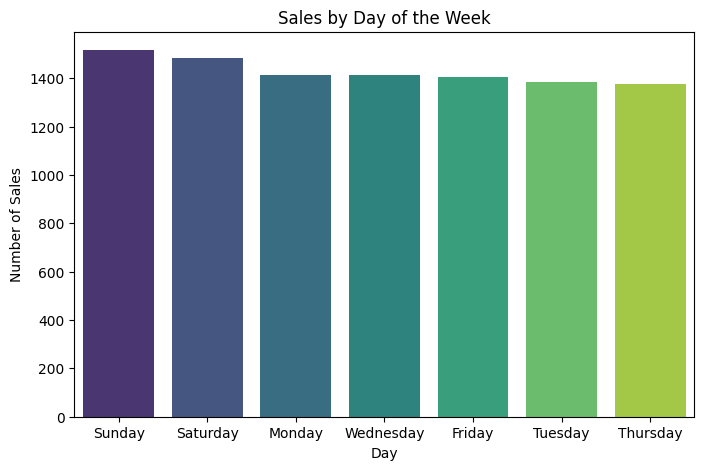

In [4]:
stmt = (
    select(
        extract('dow', Orden.fecha_orden).label('day_of_week'),
        func.count().label('sales_count')
    )
    .group_by('day_of_week')
    .order_by(func.count().desc())
)
result = session.execute(stmt).all()

days_map = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_days = pd.DataFrame(result, columns=['day_of_week', 'sales_count'])
df_days['day_name'] = df_days['day_of_week'].apply(lambda x: days_map[int(x)])

plt.figure(figsize=(8,5))
sns.barplot(x='day_name', y='sales_count', data=df_days, palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Sales')
plt.show()

Weekends are the days with the highest sales, which could be due to people having more time to shop online during those days.
Thursday has the lowest sales, so offering discounts on this day could help attract more customers.

## 3. Average profit per order


In [28]:
# Calcula el promedio de dinero generado por cada orden (dato numérico)
stmt_avg_order = select(func.avg(Orden.total))
avg_order_value = session.execute(stmt_avg_order).scalar_one()

print(f"Average order value (profit per order): ${avg_order_value:.2f}")

Average order value (profit per order): $507.76


## 4. Payment Method Distribution


C:\Users\Pedro\AppData\Local\Temp\ipykernel_12384\2655384574.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='payment_method', x='count', data=df_payments, palette='crest', orient='h')


Text(0.5, 0, 'Number of Orders')

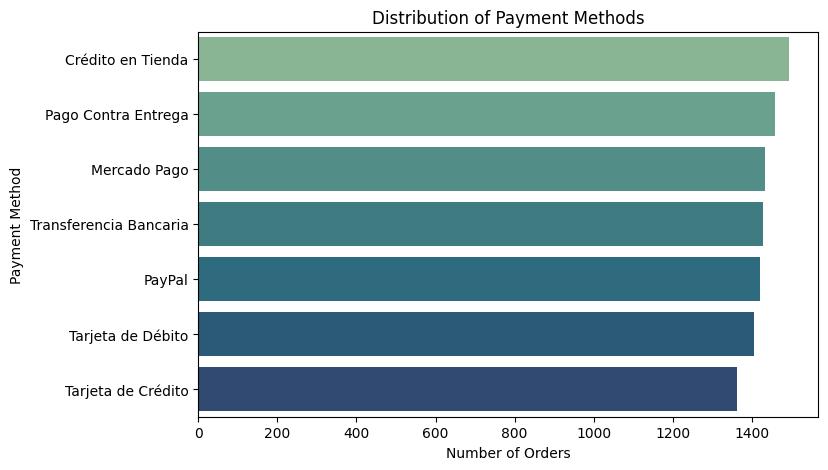

In [13]:
stmt = (
    select(MetodoPago.nombre, func.count().label("count"))
    .select_from(OrdenMetodoPago)
    .join(MetodoPago, OrdenMetodoPago.metodo_pago_id == MetodoPago.metodo_pago_id)
    .group_by(MetodoPago.nombre)
)
result = session.execute(stmt).all()
df_payments = pd.DataFrame(result, columns=['payment_method', 'count'])

# Sort by count descending
df_payments = df_payments.sort_values(by='count', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(y='payment_method', x='count', data=df_payments, palette='crest', orient='h')
plt.title('Distribution of Payment Methods')
plt.ylabel('Payment Method')
plt.xlabel('Number of Orders')

- **El crédito en tienda** fue el medio de pago más utilizado.  
  Esto podría deberse a que los clientes lo perciben como una forma de "dinero gratis".

- **La tarjeta de crédito** fue el medio menos utilizado.
----

## 5. Order Value by Payment Method

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Tarjeta de Débito'),
  Text(1, 0, 'Pago Contra Entrega'),
  Text(2, 0, 'Crédito en Tienda'),
  Text(3, 0, 'Transferencia Bancaria'),
  Text(4, 0, 'Mercado Pago'),
  Text(5, 0, 'Tarjeta de Crédito'),
  Text(6, 0, 'PayPal')])

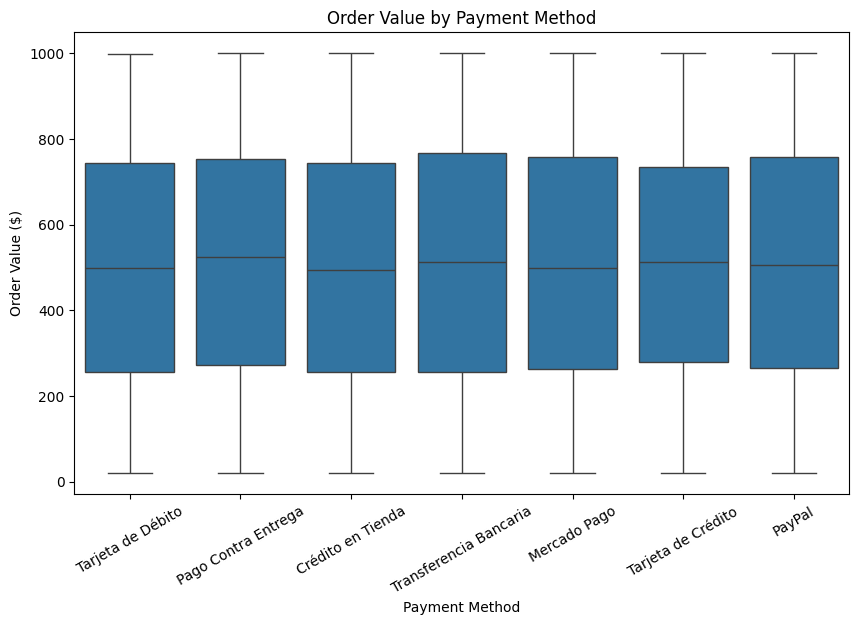

In [31]:
# Scatterplot: Payment Method vs. Order Value

# Trae el nombre del método de pago y el total de cada orden
stmt = (
    select(
        MetodoPago.nombre.label('payment_method'),
        Orden.total.label('order_total')
    )
    .select_from(OrdenMetodoPago)
    .join(Orden, OrdenMetodoPago.orden_id == Orden.orden_id)
    .join(MetodoPago, OrdenMetodoPago.metodo_pago_id == MetodoPago.metodo_pago_id)
)
result = session.execute(stmt).all()
df_scatter = pd.DataFrame(result, columns=['payment_method', 'order_total'])

plt.figure(figsize=(10,6))
sns.boxplot(x='payment_method', y='order_total', data=df_scatter)
plt.title('Order Value by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Order Value ($)')
plt.xticks(rotation=30)

## Conclusión
El dataset presenta una distribución de datos muy homogénea, lo cual limita la posibilidad de detectar patrones o insights significativos. Incluir cierta variabilidad o “ruido” controlado podría haber facilitado un análisis más rico y realista.